# DSI Capstone - Part 2 

### Summary
For my capstone project, I will be entering the Avazu Click-Through Rate Prediction competition on Kaggle (https://www.kaggle.com/c/avazu-ctr-prediction).  This competition ended three years ago but is still open for late submissions.

### Goals
My primary goal is to achieve a score which would have been sufficient to reach the top 1/3 of the leaderboard during the contest. This is a score of 0.3930207, which would have achieved a ranking of 534 of 1604 entrants (the precision is important for ranking in this contest, where many scores are separated by very small margins).  The top score in this contest was 0.3791384. Submissions are evaluated by Logarithmic Loss (lower scores are better). 

A secondary goal is to understand Neural Networks in depth since this is one of the model techniques I plan to use. 

A potential third (stretch) goal would be to test whether a model pipeline developed for this contest could be quickly repurposed for a different click prediction contest (eg https://www.kaggle.com/c/criteo-display-ad-challenge).  

### Data
This is a classification problem where the goal is to predict whether a user will click a given text ad. There are ~40MM rows in the training data set, representing 10 days of data from the Avazu site, and ~4MM rows in the test set, representing one day of data.  

Preliminary data analysis follows in this notebook. In general the data appears to be well-formatted and consistent, with no null values present in either the test or the train set.

The size of the data (training set: ~6GB) presents some issues. The initial file has been split into several pieces using `shift`, and Git-LFS is being used to manage links to GitHub's Large File Storage system. GitHub has two file limits: files over 100MB require Git-lfs, and files over 2GB are unsupported. Code in the notebooks assembles a dataframe from all the different files. 

It is anticipated that certain operations may require memory- and cpu-saving approaches for work on my local machine (8GB RAM).

### Methodology
I plan to use a Neural Network approach to begin with, based on my interest in learning more about NN topology.  I am planning to use a Count Binarization technique to represent categorical values such as Device ID and Device IP with conditional probabilities. I am considering separate pipelines for ads which the model has seen before and ads which are new. All models will be cross-validated in training.

The winning approaches for the Criteo competition (another click prediction competition) included such interesting techniques including Field Aware Factorization Machines and Vowpal Wabbit's implementation of Logistic Regression. One of these might be an interesting alternative to test once the Neural Network work reaches a good point.

With 6GB of training data, I anticipate that model training and feature engieering may take time, depending on the approaches involved. I plan to create smaller test sets to use for initial model evaluation and fitting but do anticipate that final model training will be time-intensive. It is possible that I may look for a cloud instance with more cores/RAM than my local system, if necessary.  The local system is a dual-core Macbook Air with 8GB of RAM.

In [1]:
# Exploratory Data Analysis for DSI Capstone Project

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix, autocorrelation_plot
import seaborn as sns

In [3]:
# loading in test data as well as the Sample Submission file
sample = pd.read_csv('../assets/sampleSubmission')
test = pd.read_csv('../assets/test')


In [4]:
# Because of GitHub space limits (no files over 2GB), train data file was split into 5 pieces

# Loading the first file with header row to use for column names
trainaa = pd.read_csv("../assets/trainaa")

In [5]:
# Loading subsequent files as separate dataframes with common column names
trainab = pd.read_csv("../assets/trainab", header=None, names=trainaa.columns)
trainac = pd.read_csv("../assets/trainac", header=None, names=trainaa.columns)
trainad = pd.read_csv("../assets/trainad", header=None, names=trainaa.columns)
trainae = pd.read_csv("../assets/trainae", header=None, names=trainaa.columns)

In [6]:
# Concatenating all files into one training set for EDA purposes
train = pd.concat([trainaa, trainab, trainac, trainad, trainae], ignore_index=True)

In [7]:
# Note that we have ~10x more data in our training dataset than in our testing dataset
# The training set corresponds to 10 days of web ad click data, and the test set corresponds to day 11 
print(f"Sample submission shape: {sample.shape} - Train shape: {train.shape} - Test shape: {test.shape}")

Sample submission shape: (4577464, 2) - Train shape: (40428967, 24) - Test shape: (4577464, 23)


In [8]:
# Examining the sample submission format

sample.head(1)

,id,click
0,10000174058809263569,0.5


In [9]:
# Examining the training data format

train.head(1)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79


In [10]:
# Examining the test data format - it looks identical to train except for the "click" column, as expected

test.head(1)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23


In [11]:
# Verifying that "click" is the only column present in train which is not in test

[item for item in list(train.columns.values) if item not in list(test.columns.values)]

['click']

In [12]:
# Verifying that there are no columns present in test which are not in train

[item for item in list(test.columns.values) if item not in list(train.columns.values)]

[]

In [13]:
# Checking nulls in training data - looks good

train.isnull().sum().sum()

0

In [14]:
# Checking nulls in test data - also looking good

test.isnull().sum().sum()

0

## Reviewing data types 

train.info()

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4577464 entries, 0 to 4577463
Data columns (total 23 columns):
id                  float64
hour                int64
C1                  int64
banner_pos          int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         int64
device_conn_type    int64
C14                 int64
C15                 int64
C16                 int64
C17                 int64
C18                 int64
C19                 int64
C20                 int64
C21                 int64
dtypes: float64(1), int64(13), object(9)
memory usage: 803.2+ MB


In [16]:
# Our class balance is 83% - 17% -- imbalanced classes, although not as extreme as in other cases like disease detection
# From the documentation, the datasets have been modified to increase the relative size of the minority class

train.click.value_counts(normalize=True)

0    0.830194
1    0.169806
Name: click, dtype: float64

In [17]:
# Getting a sense for the different columns in our dataset

In [18]:
# How many unique values does each column contain?

unique_values = pd.DataFrame(index=train.columns)
for col_name in list(train.columns):
    unique_values.at[col_name, "unique_vals"] = len(train[col_name].unique())
unique_values

,unique_vals
id,40428967.0
click,2.0
hour,240.0
C1,7.0
banner_pos,7.0
site_id,4737.0
site_domain,7745.0
site_category,26.0
app_id,8552.0
app_domain,559.0


In [19]:
# Let's look at the numeric columns we have
numeric_cols = train.select_dtypes(exclude='object').drop(columns=['id'])


In [20]:
numeric_cols.head()
#sns.pairplot(numeric_cols)

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,14102100,1005,0,1,2,15706,320,50,1722,0,35,-1,79
1,0,14102100,1005,0,1,0,15704,320,50,1722,0,35,100084,79
2,0,14102100,1005,0,1,0,15704,320,50,1722,0,35,100084,79
3,0,14102100,1005,0,1,0,15706,320,50,1722,0,35,100084,79
4,0,14102100,1005,1,1,0,18993,320,50,2161,0,35,-1,157


In [21]:
# Let's examine the object columns in more detail since they will need to be transformed

# these all look like anonymized categorical values... pretty straightforward
object_cols = train.select_dtypes(include='object')
object_cols.head(10)

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model
0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24
1,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120
2,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd
3,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a
4,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2
5,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,05241af0,8a4875bd
6,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,b264c159,be6db1d7
7,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,be74e6fe
8,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,37e8da74,5db079b5
9,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6


In [22]:
# looking into Hour... looks like it's a sequential list of dates with hour identifiers from 00 to 23 
hour_counts = train.groupby(['hour']).size().reset_index(name='counts')
hour_counts.head(24)

,hour,counts
0,14102100,119006
1,14102101,137442
2,14102102,207471
3,14102103,193355
4,14102104,264711
5,14102105,273500
6,14102106,239720
7,14102107,209311
8,14102108,207244
9,14102109,230917


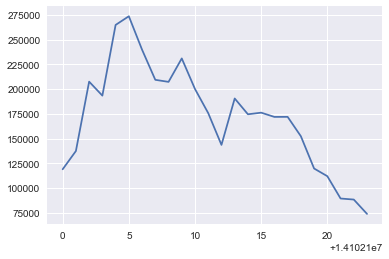

In [23]:
# specifically this looks like observations drawn over a 10 day period
# hour-of-the-day, day-of-the-week, and day-of-the-month may be relevant

# "Day One" events by hour
plt.xscale('linear')
plt.plot(hour_counts.hour[0:24], hour_counts.counts[0:24])

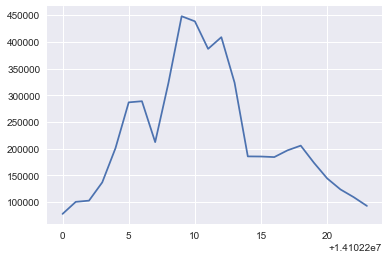

In [24]:
# "Day Two" events by hour
plt.plot(hour_counts.hour[24:48], hour_counts.counts[24:48])

In [25]:
# Initial hypothesis : BalancedBaggingClassifier may perform well. Experiment: "bin counting" with probabilities to replace categoricals such as IP / device ID

In [26]:
# TODO: create DateTime column for time-based visualizations

In [27]:
# TODO: examine values in test not present in train

In [32]:
def diff_categoricals(reference_col, test_col):
    set_1 = list(reference_col.unique())
    set_2 = list(test_col.unique())
    return str([x for x in test_col if x not in reference_col])

In [33]:
diff_categoricals(train.C1, test.C1)

'[]'

In [ ]:
# TODO: prepare submission with ids from test set